GRID SIZE:  10
Data shape: (100, 2)
Initialized with NEigs = 100 (type: <class 'int'>)


/Users/seoli/Desktop/DIAMONDS/Tufts2024/lund/utils.py:77: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigvals, eigvecs = eigs(P, k = n_eigs)


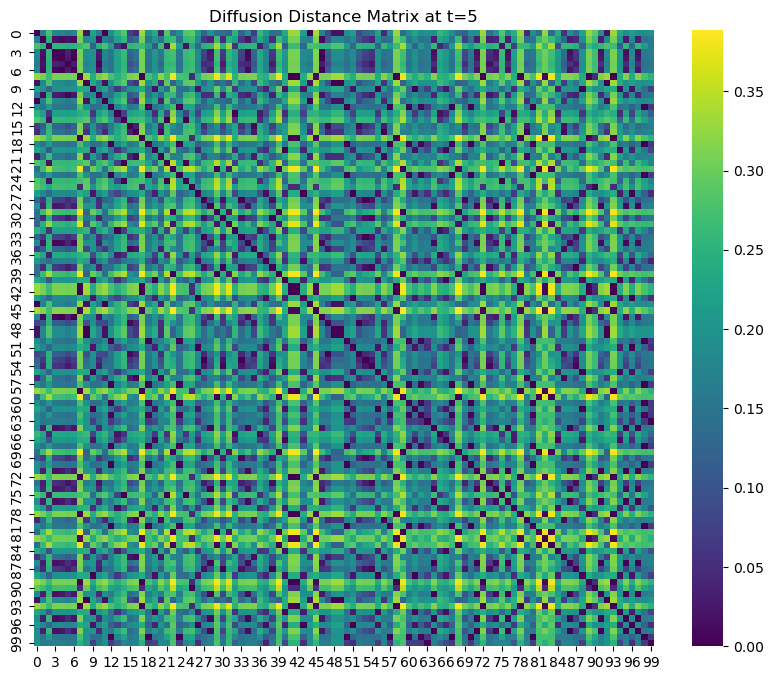

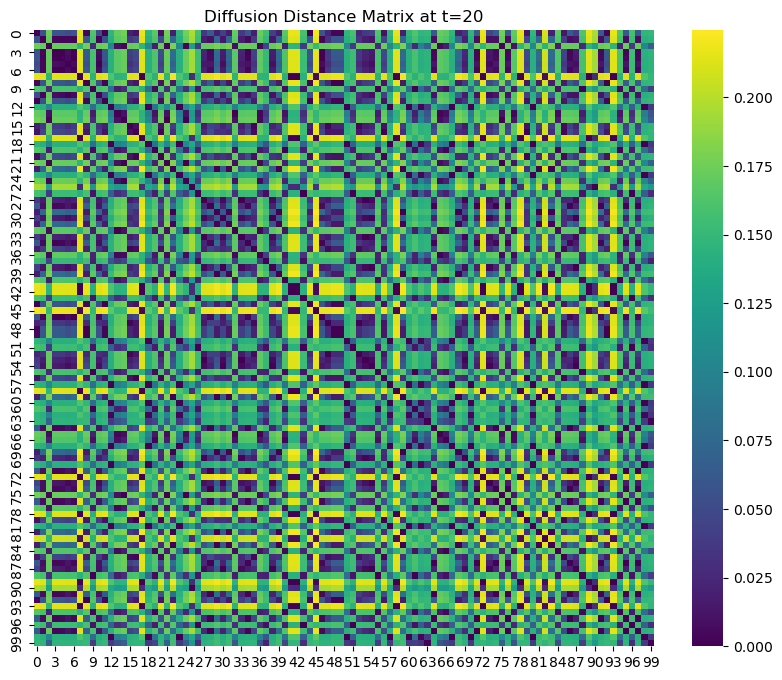

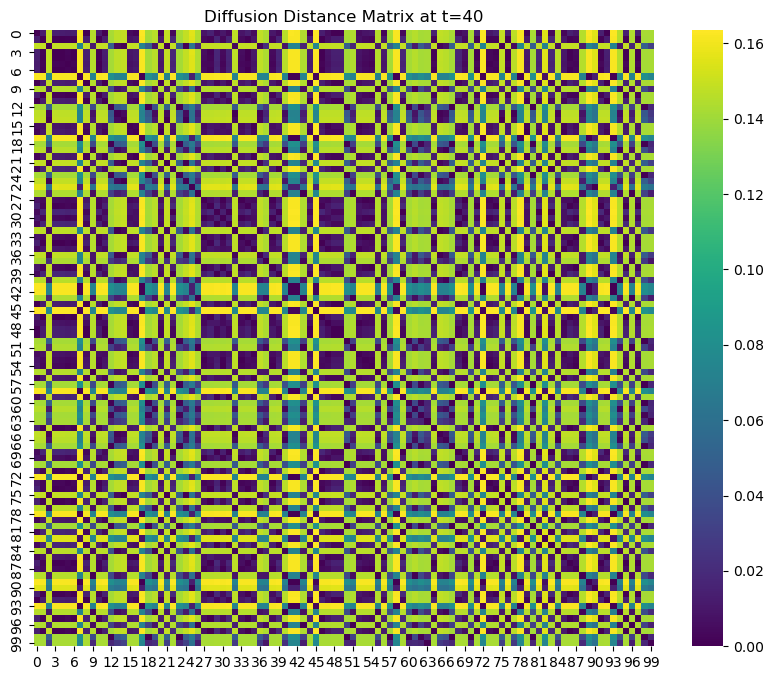

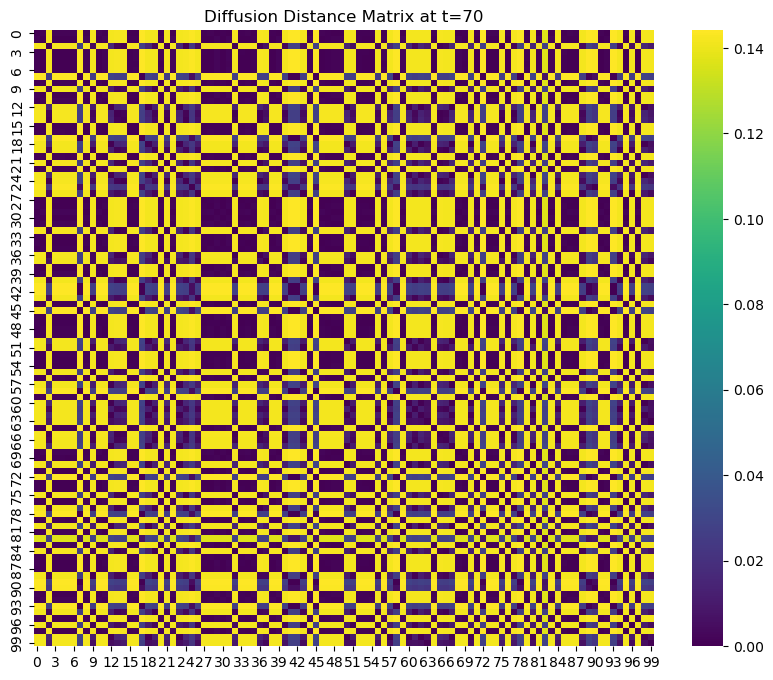

entered lund
Number of Eigenvalues: 100
Number of Eigenvectors: (100, 100)
replicate error
m_sorting: [16 18 90 41 63 82 37 61 26 30 45 62 94 31 77 19  5  0 69 35 32  2 66  6
 65 84 99 72 85 47 58 15  8 53  1 73 36 20 21 95 83  3 51 10 54 78 34 13
  7 25 96 28 91 42 75 89 59 93 79 74 50 24 22 39 56 49 57 87 43 17 68 27
 40 33  9 52 55 64 76 92 70 46 97 38 48 67 11 80  4 29 81 44 86 60 71 23
 98 88 12 14]
Number of clusters K: 2
Number of clusters: 2
Aligned Accuracy: 1.0


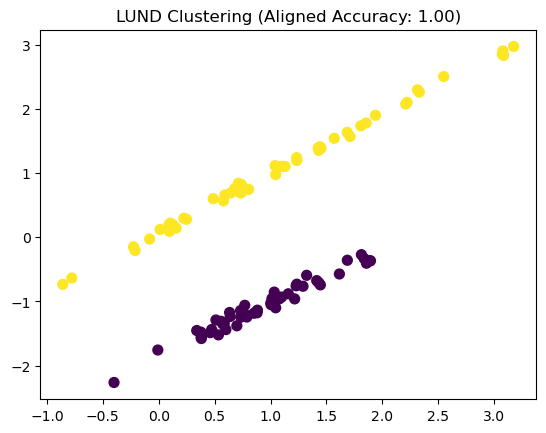

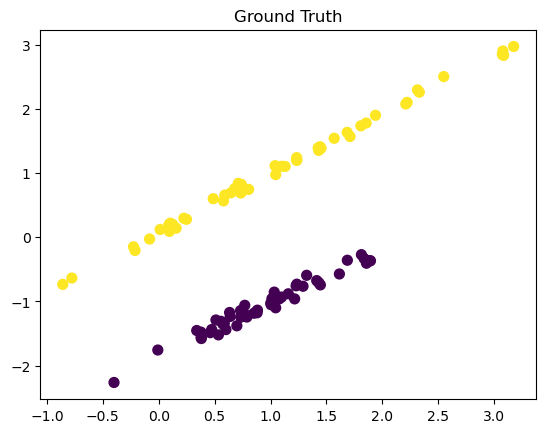

In [3]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io


# data_path, gt_path, data_name, gt_name = '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_corrected.mat', '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt'


# X, M, N, D, HSI, GT, Y, n, K = loadHSI(data_path, gt_path, data_name, gt_name)
X, GT = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
scipy.io.savemat('data.mat', {'X': X, 'GT': GT})

grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)

# GT = GT - 1
# HSI = X.reshape((M, N, D))
Hyperparameters = {
    'Sigma': 1.0,
    'DiffusionNN': 10,
    
}

kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)

graph_extractor = GraphExtractor()
G = graph_extractor.extract_graph(X)



def plot_diffusion_distance(timestep):
    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at t={timestep}')
    plt.show()

plot_diffusion_distance(5)
plot_diffusion_distance(20)
plot_diffusion_distance(40)
plot_diffusion_distance(70)


C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 70, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")
# plot_kde_density(X, "KDE Density Estimation")

# kmeans = KMeans(n_clusters=2, random_state=42)
# kmeans_labels = kmeans.fit_predict(X)
# kmeans_accuracy = calculate_aligned_accuracy(GT, kmeans_labels)
# print("Aligned Accuracy (KMeans Clustering):", kmeans_accuracy)
# plot_clusters(X, kmeans_labels, f"KMeans Clustering (Aligned Accuracy: {kmeans_accuracy:.2f})")


